## Imports

In [0]:
# Setup Keras backend as Tensorflow

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [0]:
# Import libraries for data operations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import math

In [0]:
# Import libraries for Google Drive operations

from google.colab import auth
from google.colab import drive

In [0]:
# Import libraries for Keras

import tensorflow as tf
import keras

from keras import regularizers
from keras import backend as K

from keras.models import Sequential, Model

from keras.layers import *
from keras.optimizers import *

from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant


from keras.utils import np_utils
from keras_preprocessing.image import ImageDataGenerator


from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.applications.mobilenetv2 import MobileNetV2
from keras.layers.advanced_activations import LeakyReLU

from sklearn.metrics import roc_curve
from sklearn.metrics import auc


Using TensorFlow backend.


## Data loading 

In [0]:
# Mount Google Drive

drive.mount('./drive')

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [0]:
# Google Drive paths

gdrive_root = '/content/drive/My Drive'
ml_location = os.path.join(gdrive_root, 'ml')
final_project_location = os.path.join(ml_location, 'final_project')

def getFileLocation(file_name):
  return os.path.join(final_project_location, file_name)


In [0]:
# Load training labels

y_train = pd.read_csv(getFileLocation('y_train.csv'))
y_train.head()

,id,label
0,ISIC_0006557,benign
1,ISIC_0011182,benign
2,ISIC_0002824,benign
3,ISIC_0001336,benign
4,ISIC_0011481,malignant


In [0]:
# Load testing labels

y_test = pd.read_csv(getFileLocation('y_test.csv'))
y_test.head()

,id,label
0,ISIC_0031419,benign
1,ISIC_0009932,benign
2,ISIC_0000881,benign
3,ISIC_0026953,benign
4,ISIC_0024963,benign


In [0]:
# Add training and testing data

y = pd.concat([y_train, y_test])
y.head()

,id,label
0,ISIC_0006557,benign
1,ISIC_0011182,benign
2,ISIC_0002824,benign
3,ISIC_0001336,benign
4,ISIC_0011481,malignant


In [0]:
print("Number of training examples metadata %d" % len(y_train))
print("Number of testing examples metadata %d" % len(y_test))
print("Number of overall examples metadata %d" % len(y))

Number of training examples metadata 13685
Number of testing examples metadata 3422
Number of overall examples metadata 17107


In [0]:
# Get path to training images folder

training_images = 15933

train_img_path = getFileLocation('x_train')

In [0]:
# Get path to testing images folder

test_images = 3422

test_img_path = getFileLocation('x_test')

## Data generators

In [0]:
# Keras constants

rotation_range = 45
image_size = (224, 224)
batch_size = 128

num_epochs = 40
input_image_shape = (224,224,3)
num_classes = 1

num_of_training_img = training_images
num_of_testing_img = test_images

num_batches_train = math.ceil(num_of_training_img / batch_size)
num_batches_test = math.ceil(num_of_testing_img / batch_size)

In [0]:
# Data generators

train_datagenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range = rotation_range)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow directory generators

train_generator = train_datagenerator.flow_from_directory(
        train_img_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        test_img_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')

Found 15953 images belonging to 2 classes.
Found 3422 images belonging to 2 classes.


# Model creation

## MobileNet v2

In [0]:
# Build model based on MobileNetV2

input_tensor = Input(shape = input_image_shape)

base_model = MobileNetV2(
    include_top = False,
    weights = 'imagenet',
    input_tensor = input_tensor,
    input_shape = input_image_shape,
    pooling = 'max')


output_tensor = Dense(1, activation = 'sigmoid')(base_model.output)

mobilenet_model = Model(inputs = input_tensor, outputs = output_tensor)

mobilenet_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0]

In [0]:
# Model checkpoint and additional metrics

filepath_basic_mobilenet = "weights_best_mobilenet_adam.hdf5"
checkpoint = ModelCheckpoint(filepath_basic_mobilenet, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
# Compile the model

opt_lr = 0.0001
opt_decay = 1e-6

optimizer = keras.optimizers.rmsprop(lr = opt_lr, decay = opt_decay)

mobilenet_model.compile(
    optimizer = optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [0]:
# Train the model

mobilenet_history = mobilenet_model.fit_generator(
    generator = train_generator,
    steps_per_epoch = num_batches_train,
    validation_data = validation_generator,
    validation_steps = num_batches_test,
    epochs = num_epochs,
    callbacks = [checkpoint],
    verbose = 1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/40
125/125 [==============================] - 6959s 56s/step - loss: 0.3724 - acc: 0.8684 - val_loss: 0.3085 - val_acc: 0.9068

Epoch 00001: val_acc improved from -inf to 0.90678, saving model to weights_best_mobilenet_adam.hdf5
Epoch 2/40
125/125 [==============================] - 216s 2s/step - loss: 0.2620 - acc: 0.9001 - val_loss: 0.3238 - val_acc: 0.9074

Epoch 00002: val_acc improved from 0.90678 to 0.90736, saving model to weights_best_mobilenet_adam.hdf5
Epoch 3/40
125/125 [==============================] - 228s 2s/step - loss: 0.2276 - acc: 0.9107 - val_loss: 0.2862 - val_acc: 0.9117

Epoch 00003: val_acc improved from 0.90736 to 0.91175, saving model to weights_best_mobilenet_adam.hdf5
Epoch 4/40
125/125 [==============================] - 226s 2s/step - loss: 0.1904 - acc: 0.9252 - val_loss: 0.2802 - val_acc: 0.9196

Epoch 00004: val_acc improv

## Evaluate the model

In [0]:
results = mobilenet_model.evaluate_generator(validation_generator, steps = num_batches_test)

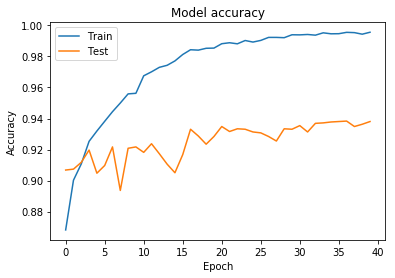

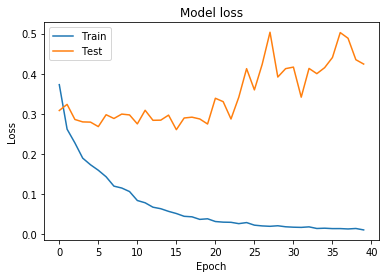

In [0]:
# Plots for accuracy

plt.plot(mobilenet_history.history['acc'])
plt.plot(mobilenet_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plots for loss

plt.plot(mobilenet_history.history['loss'])
plt.plot(mobilenet_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Predictions 

In [0]:
predictions = mobilenet_model.predict_generator(validation_generator, steps = num_batches_test)

## Save model

In [0]:
# Function to get TF session

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [0]:
# Create *.pb model file

from keras import backend as K
frozen_graph = freeze_session(K.get_session(), output_names = [out.op.name for out in mobilenet_model.outputs])
tf.train.write_graph(frozen_graph, final_project_location, 'mobilenet_model.pb', as_text = False)

INFO:tensorflow:Froze 632 variables.
INFO:tensorflow:Converted 632 variables to const ops.


'/content/drive/My Drive/ml/final_project/mobilenet_model.pb'

In [0]:
# Reconstruct TF model

from tensorflow.python.platform import gfile
with tf.Session() as sess:
  # Load model from pb file
  with gfile.FastGFile('graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    g_in = tf.import_graph_def(graph_def)

In [0]:
# Write model to tensorboard

writer = tf.summary.FileWriter(final_project_location + "/log")
writer.add_graph(sess.graph)
writer.flush()
writer.close()